In [ ]:
# Install Kaggle package
!pip install -q kaggle

# Upload your Kaggle API JSON file
from google.colab import files
files.upload()

# Create a directory for Kaggle and move your kaggle.json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle (Replace <dataset-identifier> with the actual dataset identifier)
!kaggle datasets download -d mariafrenti/age-prediction

# Unzip the dataset (Replace <dataset-name>.zip with the actual zip file name)
!unzip age-prediction.zip


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from glob import glob

# Paths to the dataset
train_dir = '/content/20-50/20-50/train'  # Replace with actual train directory path
test_dir = '/content/20-50/20-50/test'    # Replace with actual test directory path

# Count the number of images in the dataset
num_train_images = len(glob(train_dir + '/*/*.jpg'))
num_test_images = len(glob(test_dir + '/*/*.jpg'))
print(f"Number of training images: {num_train_images}")
print(f"Number of testing images: {num_test_images}")

# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


Number of training images: 7008
Number of testing images: 33432
Found 5620 images belonging to 31 classes.
Found 1388 images belonging to 31 classes.
Found 33432 images belonging to 31 classes.


In [ ]:
# Choose between ResNet50 or EfficientNetB0
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# or
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Model checkpoint to save best weights
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_mae', save_best_only=True, save_weights_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

# Load the best weights
model.load_weights('best_model.weights.h5')


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1439s 8s/step - loss: 78.9963 - mae: 7.6343 - val_loss: 80.3516 - val_mae: 7.7461
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1464s 8s/step - loss: 79.4589 - mae: 7.6828 - val_loss: 80.8083 - val_mae: 7.7711
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1414s 8s/step - loss: 82.4893 - mae: 7.8532 - val_loss: 82.2530 - val_mae: 7.8200
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1436s 8s/step - loss: 81.6018 - mae: 7.7971 - val_loss: 82.2277 - val_mae: 7.7832


In [ ]:
from google.colab import files
model.save('age_prediction_model_resnet.keras')
# Download the model file
files.download('age_prediction_model_resnet.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test MAE: {test_mae}")


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 6764s 6s/step - loss: 79.3546 - mae: 7.6799
Test MAE: 7.690605163574219


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_age(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    age_prediction = model.predict(img_array)
    return age_prediction[0][0]

# Example usage
image_path = 'dheva.jpg'  # Replace with the path to your image
predicted_age = predict_age(image_path)
print(f"Predicted Age: {predicted_age}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Age: 14.993906021118164


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_age(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    age_prediction = model.predict(img_array)
    return age_prediction[0][0]

# Example usage
image_path = 'ayya.jpg'  # Replace with the path to your image
predicted_age = predict_age(image_path)
print(f"Predicted Age: {predicted_age}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predicted Age: 14.774633407592773


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted age: 31.623281478881836 years


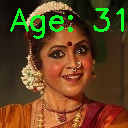

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

# Load the model from the .h5 file
model = tf.keras.models.load_model('/content/age_prediction_model_resnet.keras')

def predict_age(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Resize the image to the input size expected by the model
    img_resized = cv2.resize(img, (224, 224))  # ResNet typically uses 224x224 input size

    # Preprocess the image
    img_resized = preprocess_input(np.array(img_resized, dtype=np.float32))
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    # Predict the age
    predicted_age = model.predict(img_resized)

    # Display the result
    print(f"Predicted age: {predicted_age[0][0]} years")

    # Optionally, show the image with the predicted age
    cv2.putText(img, f'Age: {int(predicted_age[0][0])}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (36, 255, 12), 2)
    cv2_imshow(img)  # Use cv2_imshow instead of cv2.imshow

# Test the function
predict_age('/content/50im2.jpg')  # Replace with your image path


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
!pip install tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 860.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 231.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0
